In [7]:
# Prepare Photo Data
from os import listdir
from os.path import isfile
from pickle import dump
from tqdm import tqdm
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.utils import load_img
from keras.utils import img_to_array
import matplotlib.pyplot as plt

# Prepare Text Data
import string

# Load Data
from pickle import load

# Encode Text Data
from keras.preprocessing.text import Tokenizer

from keras.utils import plot_model
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
#from keras.layers.merge import add
from keras.layers import Concatenate
from keras.layers import RepeatVector, TimeDistributed, concatenate, Bidirectional

# Fit Model
import numpy as np
from keras.utils import pad_sequences
from keras.utils import to_categorical

# Evaluate Model
from numpy import argmax, argsort
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Generate Captions
from IPython.display import Image, display

In [8]:
# preprocess the image for the model
def preprocess_image(filename, image_size):
    image = load_img(filename, target_size=(image_size, image_size))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the model
    image = preprocess_input(image)
    return image

In [9]:
# extract features from each photo in the directory
def extract_features(directory, model, image_size):
	# extract features from each photo
	features = dict()
	for name in tqdm(listdir(directory), position=0, leave=True):
		# load an image from file
		filename = directory + '/' + name
		# preprocess the image for the model
		image = preprocess_image(filename, image_size)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
	return features

In [10]:
def plot(model, filename):
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=False)
    display(Image(filename))

In [11]:
from keras.applications.vgg16 import preprocess_input

In [12]:
# cnn VGG16 model
def cnn_vgg16():
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    return model

In [13]:
# get cnn vgg16 model
cnn_vgg16 = cnn_vgg16()

2022-09-29 10:55:15.617334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 10:55:20.029971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3878 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:07.0, compute capability: 7.0
2022-09-29 10:55:20.031546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3878 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:08.0, compute capability: 7.0
2022-09-29 10:55:20.033774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/repli

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

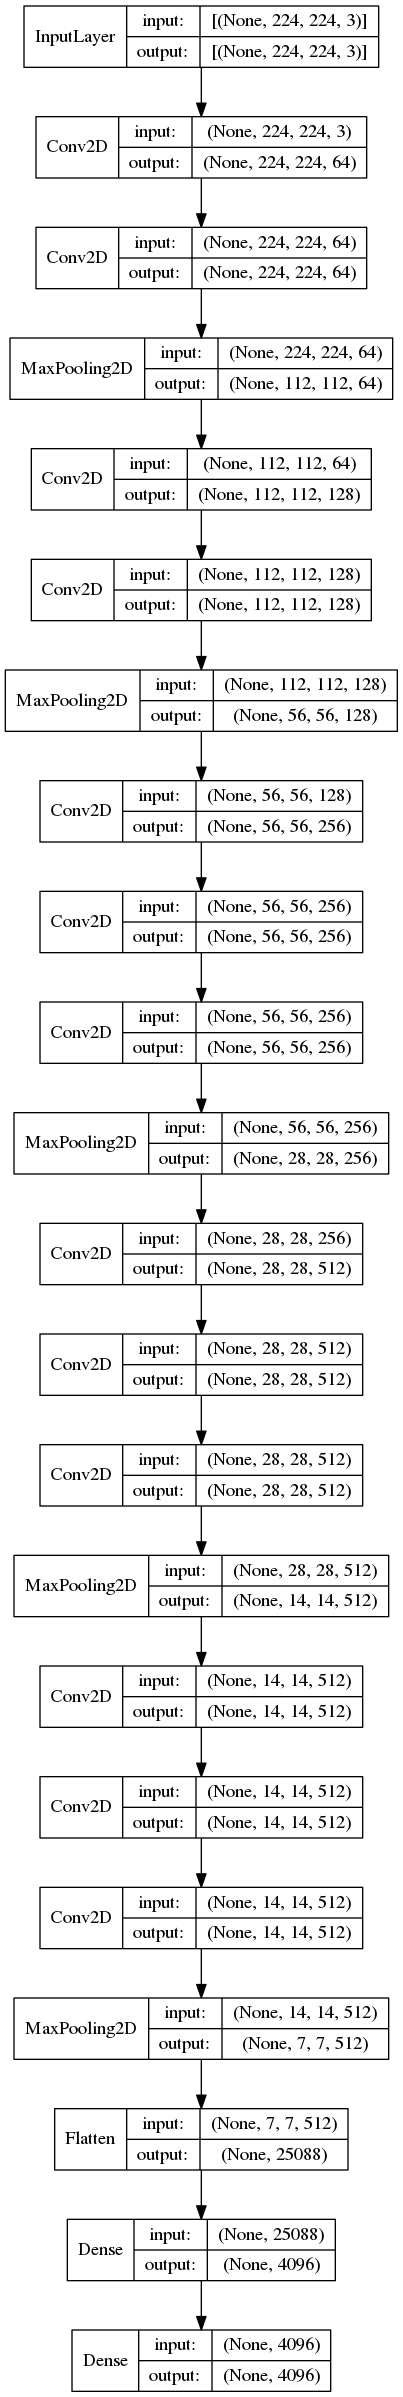

In [14]:
# plot model
filename = 'models/cnn_vgg16.png'
plot(cnn_vgg16, filename)

In [16]:
filename = 'files/features_vgg16.pkl'
# only extract if file does not exist
if not isfile(filename):
    # extract features from all images
    directory = 'datasets/Flickr8k/Flicker8k_Dataset'
    features = extract_features(directory, cnn_vgg16, 224)
    # save to file
    dump(features, open(filename, 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 8091/8091 [12:16<00:00, 10.99it/s]


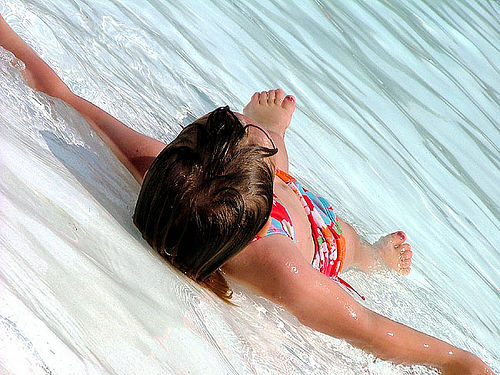

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


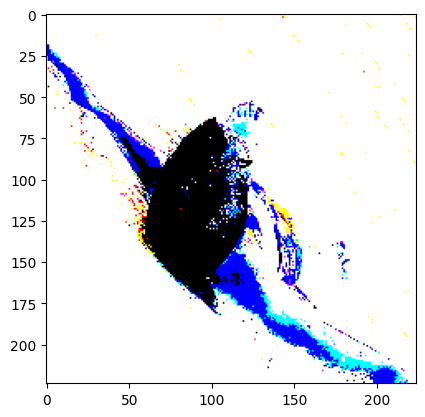

In [18]:
# display original and preprocessed image
example_image = "datasets/Flickr8k/Flicker8k_Dataset/667626_18933d713e.jpg"
display(Image(example_image))
image = preprocess_image(example_image, 224)
plt.imshow(np.squeeze(image))

In [19]:
from keras.applications.inception_v3 import preprocess_input

In [20]:
# cnn InceptionV3 model
def cnn_inceptionv3():
    # load the model
    model = InceptionV3(weights='imagenet')
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    return model

In [21]:
# get cnn inceptionv3 model
cnn_inceptionv3 = cnn_inceptionv3()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

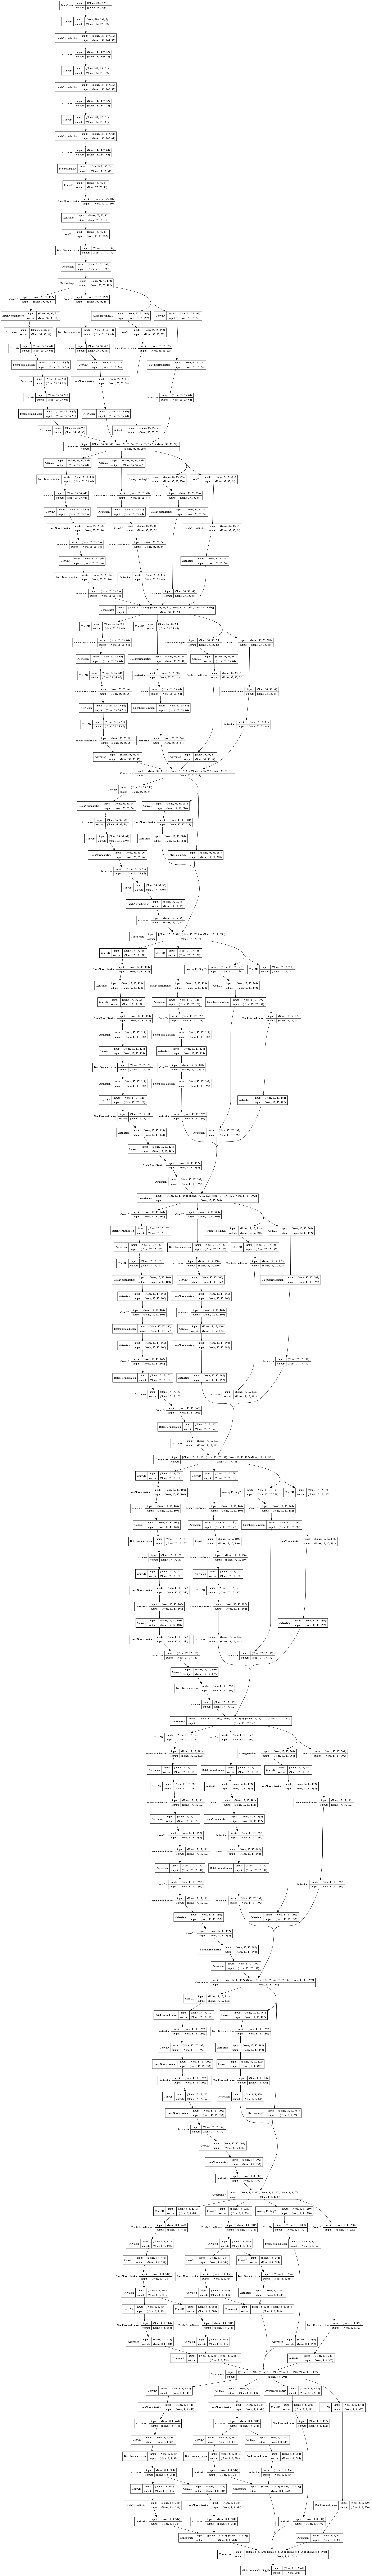

In [22]:
# plot model
filename = 'models/cnn_inceptionv3.png'
plot(cnn_inceptionv3, filename)

In [24]:
filename = 'files/features_inceptionv3.pkl'
# only extract if file does not exist
if not isfile(filename):
    # extract features from all images
    directory = 'datasets/Flickr8k/Flicker8k_Dataset'
    features = extract_features(directory, cnn_vgg16, 224)
    # save to file
    dump(features, open(filename, 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 8091/8091 [12:09<00:00, 11.09it/s]


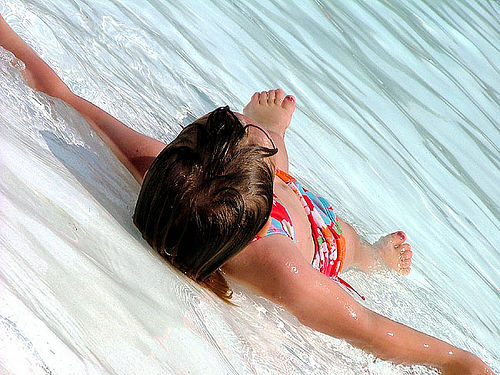

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


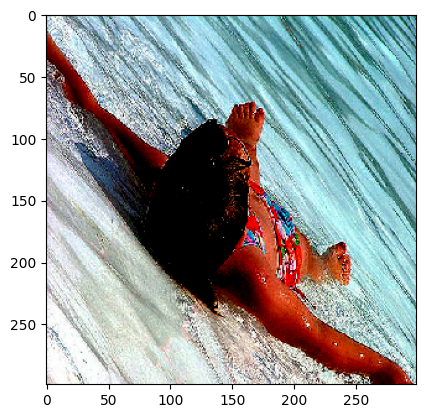

In [25]:
# display original and preprocessed image
example_image = "datasets/Flickr8k/Flicker8k_Dataset/667626_18933d713e.jpg"
display(Image(example_image))
image = preprocess_image(example_image, 299)
plt.imshow(np.squeeze(image))

In [26]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [27]:
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

In [28]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

In [29]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

In [30]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [31]:
filename = 'datasets/Flickr8k/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


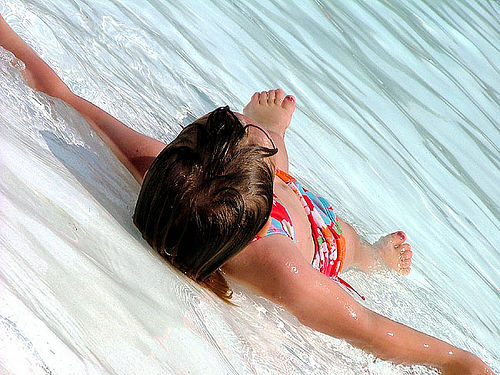

In [32]:
display(Image(example_image))

In [33]:
example_id = '667626_18933d713e'
descriptions[example_id]

['A girl is stretched out in shallow water',
 'A girl wearing a red and multi-colored bikini is laying on her back in shallow water .',
 'A little girl in a red swimsuit is laying on her back in shallow water .',
 'A young girl is lying in the sand , while ocean water is surrounding her .',
 'Girl wearing a bikini lying on her back in a shallow pool of clear blue water .']

In [34]:
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'files/descriptions.txt')

Vocabulary Size: 8763


In [35]:
descriptions[example_id]

['girl is stretched out in shallow water',
 'girl wearing red and multicolored bikini is laying on her back in shallow water',
 'little girl in red swimsuit is laying on her back in shallow water',
 'young girl is lying in the sand while ocean water is surrounding her',
 'girl wearing bikini lying on her back in shallow pool of clear blue water']

In [36]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [37]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = '<start> ' + ' '.join(image_desc) + ' <end>'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [38]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [40]:
# load training dataset (6K)
filename = 'datasets/Flickr8k/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('files/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('files/features_vgg16.pkl', train) #files/features_inceptionv3 or files/features_vgg16
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


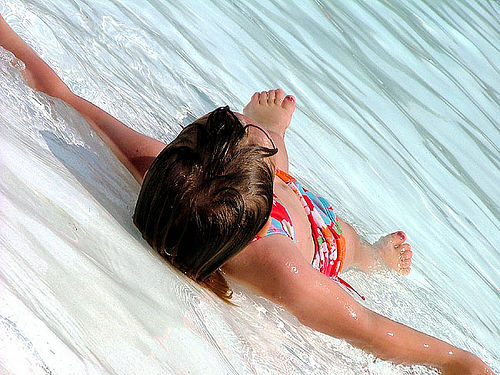

In [41]:
display(Image(example_image))

In [42]:
# <start> and <end> added
train_descriptions[example_id]

['<start> girl is stretched out in shallow water <end>',
 '<start> girl wearing red and multicolored bikini is laying on her back in shallow water <end>',
 '<start> little girl in red swimsuit is laying on her back in shallow water <end>',
 '<start> young girl is lying in the sand while ocean water is surrounding her <end>',
 '<start> girl wearing bikini lying on her back in shallow pool of clear blue water <end>']

In [43]:
# features of previous image
train_features[example_id]

array([[0.       , 0.       , 0.       , ..., 0.       , 2.8860052,
        0.       ]], dtype=float32)

In [44]:
# load val dataset
filename = 'datasets/Flickr8k/Flickr_8k.devImages.txt'
val = load_set(filename)
print('Dataset: %d' % len(val))
# descriptions
val_descriptions = load_clean_descriptions('files/descriptions.txt', val)
print('Descriptions: val=%d' % len(val_descriptions))
# photo features
val_features = load_photo_features('files/features_vgg16.pkl', val)#files/features_inceptionv3 or files/features_vgg16
print('Photos: val=%d' % len(val_features))

Dataset: 1000
Descriptions: val=1000
Photos: val=1000


In [45]:
# load test set
filename = 'datasets/Flickr8k/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('files/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('files/features_vgg16.pkl', test)#files/features_inceptionv3 or files/features_vgg16
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [46]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [47]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [48]:
# calculate the length of the description with the most words
def max_len(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [49]:
# prepare tokenizer
filename = 'files/tokenizer.pkl'
# only create tokenizer if it does not exist
if not isfile(filename):
    tokenizer = create_tokenizer(train_descriptions)
    # save the tokenizer
    dump(tokenizer, open(filename, 'wb'))
else:
    tokenizer = load(open(filename, 'rb'))
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_len(train_descriptions)
print('Description Length: %d' % max_length)

Vocabulary Size: 7579
Description Length: 34


In [50]:
# 10 most common words
list(tokenizer.word_index.items())[:10]

[('<start>', 1),
 ('<end>', 2),
 ('in', 3),
 ('the', 4),
 ('on', 5),
 ('is', 6),
 ('and', 7),
 ('dog', 8),
 ('with', 9),
 ('man', 10)]

In [51]:
# 10 least common words
list(tokenizer.word_index.items())[-10:]

[('exotic', 7569),
 ('swatting', 7570),
 ('containig', 7571),
 ('rainstorm', 7572),
 ('breezeway', 7573),
 ('cocker', 7574),
 ('spaniels', 7575),
 ('majestically', 7576),
 ('scrolled', 7577),
 ('patterns', 7578)]

In [52]:
from keras.backend import clear_session
clear_session()

In [55]:
# define the captioning model
def rnn_model_1(vocab_size, max_length, embedding_size, units, input_size):
    # feature extractor model
    inputs1 = Input(shape=(input_size,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(units)(se2)
    # decoder model
    decoder1 = Concatenate()([fe2, se3])
    decoder2 = Dense(units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model

In [56]:
# define the model
embedding_size = 256
units = 256
input_size = 4096
model = rnn_model_1(vocab_size, max_length, embedding_size, units, input_size)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 256)      1940224     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['input_3[0][0]']                
                                                                                              

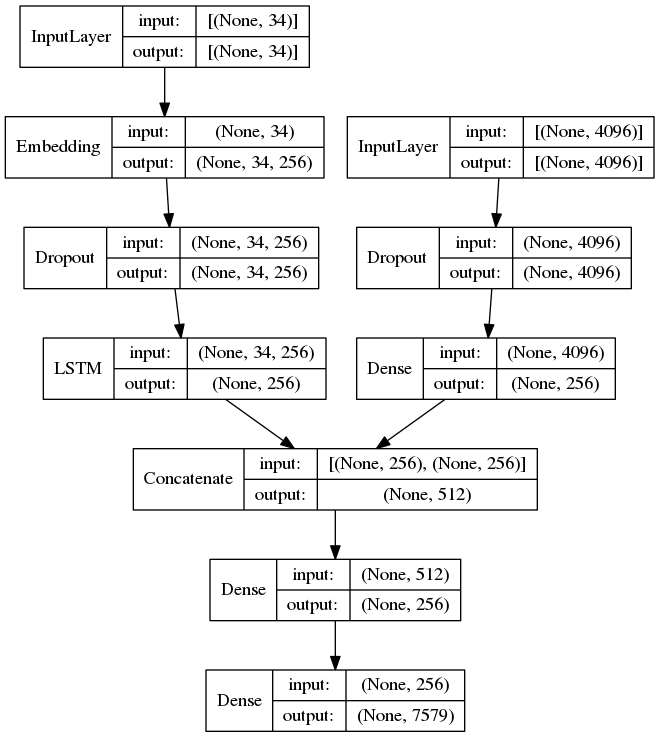

In [57]:
# plot model
filename = 'models/rnn_model_1_vgg16.png'
plot(model, filename)

In [58]:
# define the model
embedding_size = 256
units = 256
input_size = 2048
model = rnn_model_1(vocab_size, max_length, embedding_size, units, input_size)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 34, 256)      1940224     ['input_6[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

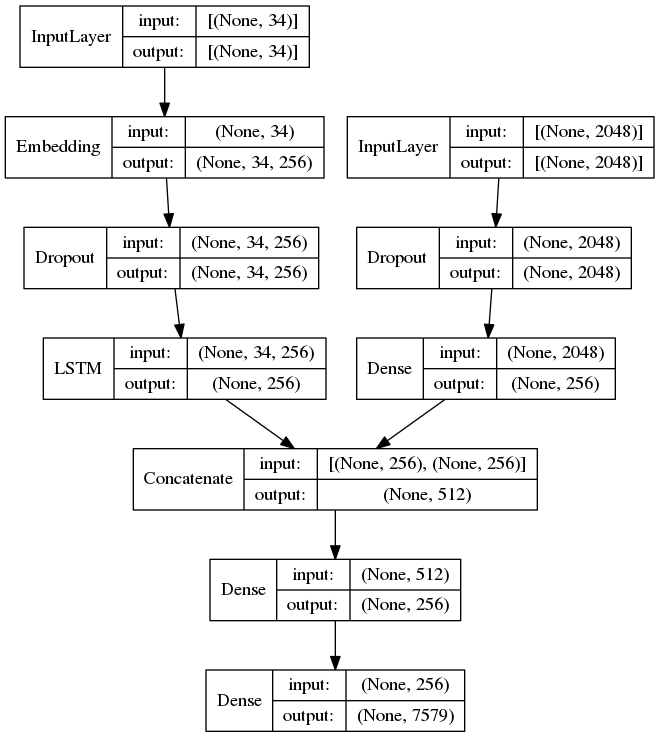

In [59]:
# plot model
filename = 'models/rnn_model_1_inceptionv3.png'
plot(model, filename)

In [60]:
# define the captioning model
def rnn_model_2(vocab_size, max_length, embedding_size, units, input_size):
    image_input = Input(shape=(input_size,))
    image_model_1 = Dense(embedding_size, activation='relu')(image_input)
    image_model = RepeatVector(max_length)(image_model_1)

    caption_input = Input(shape=(max_length,))
    # mask_zero: We zero pad inputs to the same length, the zero mask ignores those inputs
    caption_model_1 = Embedding(vocab_size, embedding_size, mask_zero=True)(caption_input)
    # Since we are going to predict the next word using the previous words, we have to set return_sequences = True.
    caption_model_2 = LSTM(units, return_sequences=True)(caption_model_1)
    caption_model = TimeDistributed(Dense(embedding_size))(caption_model_2)

    # Merging the models and creating a softmax classifier
    final_model_1 = concatenate([image_model, caption_model])
    final_model_2 = Bidirectional(LSTM(units, return_sequences=False))(final_model_1)
    final_model_3 = Dense(units, activation='relu')(final_model_2)
    final_model = Dense(vocab_size, activation='softmax')(final_model_3)

    model = Model(inputs=[image_input, caption_input], outputs=final_model)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model

In [73]:
# define the model
embedding_size = 256
units = 256
input_size = 4096
model = rnn_model_2(vocab_size, max_length, embedding_size, units, input_size)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 4096)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 34, 256)      1940224     ['input_12[0][0]']               
                                                                                                  
 dense_15 (Dense)               (None, 256)          1048832     ['input_11[0][0]']               
                                                                                            

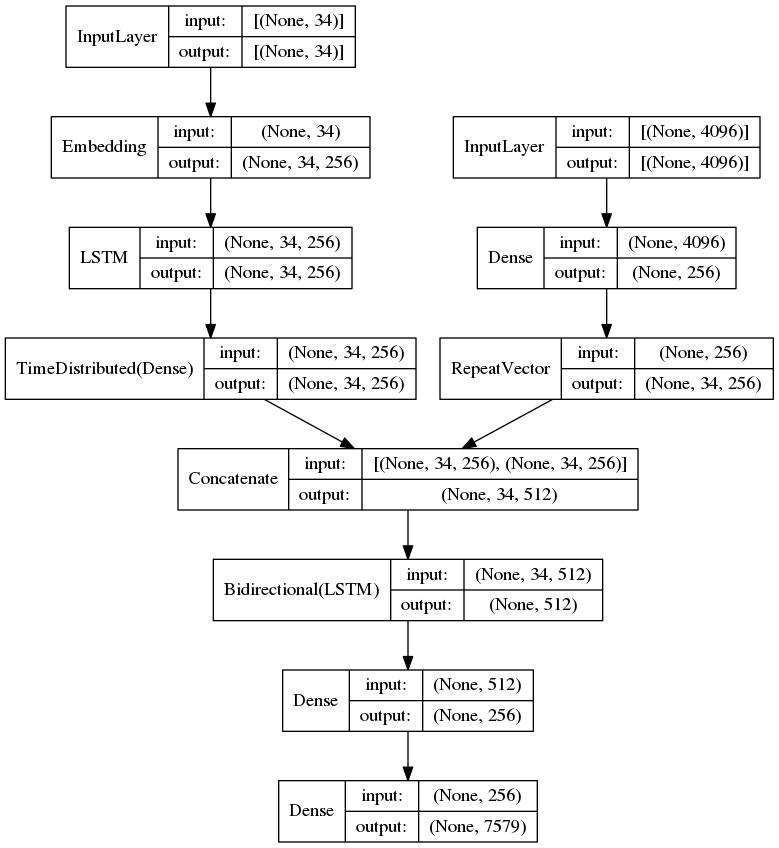

In [74]:
# plot model
filename = 'models/rnn_model_2_vgg16.png'
plot(model, filename)

In [63]:
# define the model
embedding_size = 256
units = 256
input_size = 2048
model = rnn_model_2(vocab_size, max_length, embedding_size, units, input_size)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 34, 256)      1940224     ['input_10[0][0]']               
                                                                                                  
 dense_11 (Dense)               (None, 256)          524544      ['input_9[0][0]']                
                                                                                            

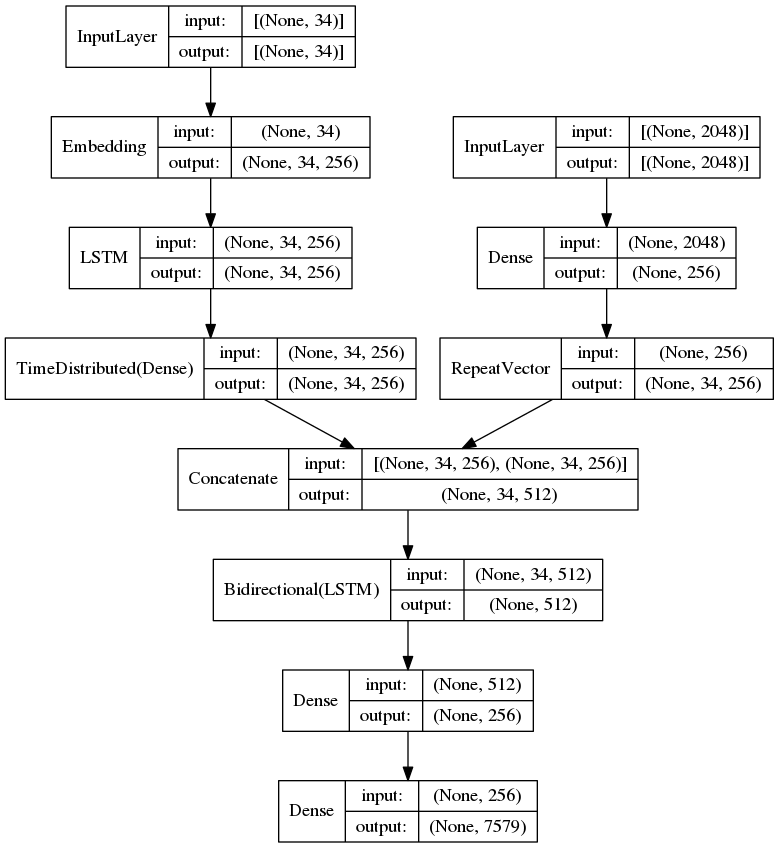

In [64]:
# plot model
filename = 'models/rnn_model_2_inceptionv3.png'
plot(model, filename)

In [75]:
# Create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, captions_list, image):
	# X1 : input for image features
	# X2 : input for text features
	# y  : output word
	X1, X2, y = list(), list(), list()
	vocab_size = len(tokenizer.word_index) + 1
	# Walk through each caption for the image
	for caption in captions_list:
		# Encode the sequence
		seq = tokenizer.texts_to_sequences([caption])[0]
		# Split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# Split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# Pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# Encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# Store
			X1.append(image)
			X2.append(in_seq)
			y.append(out_seq)
	return X1, X2, y

In [76]:
# Data generator, intended to be used in a call to model.fit()
def data_generator(images, captions, tokenizer, max_length, batch_size, random_seed):
	# Setting random seed for reproducibility of results
	random.seed(random_seed)
	# Image ids
	image_ids = list(captions.keys())
	_count=0
	while True:
		if _count >= len(image_ids):
			# Generator exceeded or reached the end so restart it
			_count = 0
		# Batch list to store data
		input_img_batch, input_sequence_batch, output_word_batch = list(), list(), list()
		for i in range(_count, min(len(image_ids), _count+batch_size)):
			# Retrieve the image id
			image_id = image_ids[i]
			# Retrieve the image features
			image = images[image_id][0]
			# Retrieve the captions list
			captions_list = captions[image_id]
			# Shuffle captions list
			random.shuffle(captions_list)
			input_img, input_sequence, output_word = create_sequences(tokenizer, max_length, captions_list, image)
			# Add to batch
			for j in range(len(input_img)):
				input_img_batch.append(input_img[j])
				input_sequence_batch.append(input_sequence[j])
				output_word_batch.append(output_word[j])
		_count = _count + batch_size
		yield ([np.array(input_img_batch), np.array(input_sequence_batch)], np.array(output_word_batch))

In [77]:
# define parameters
num_of_epochs = 20
batch_size = 32
train_length = len(train_descriptions)
val_length = len(val_descriptions)
steps_train = train_length // batch_size
if train_length % batch_size != 0:
    steps_train = steps_train+1
steps_val = val_length // batch_size
if val_length % batch_size != 0:
    steps_val = steps_val+1

In [78]:
import random
# Setting random seed for reproducibility of results
random.seed('1000')
# Shuffle train data
ids_train = list(train_descriptions.keys())
random.shuffle(ids_train)
train_descriptions = {_id: train_descriptions[_id] for _id in ids_train}

In [79]:
# Create the train data generator
generator_train = data_generator(train_features, train_descriptions, tokenizer, max_length, batch_size, random_seed='1000')
# Create the validation data generator
generator_val = data_generator(val_features, val_descriptions, tokenizer, max_length, batch_size, random_seed='1000')

In [80]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
# define checkpoint callback
filepath = 'models/rnn_model_2_vgg16.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# define early stopping callback
early = EarlyStopping(patience=1, verbose=1)

In [81]:
# Fit
history = model.fit(generator_train,
            epochs=num_of_epochs,
            steps_per_epoch=steps_train,
            validation_data=generator_val,
            validation_steps=steps_val,
            callbacks=[checkpoint, early],
            verbose=1)

Epoch 1/20


2022-09-29 12:38:25.897792: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'


188/188 [==============================] - ETA: 0s - loss: 5.7619
Epoch 1: val_loss improved from inf to 5.28069, saving model to models/rnn_model_2_vgg16.h5
188/188 [==============================] - 95s 431ms/step - loss: 5.7619 - val_loss: 5.2807
Epoch 2/20
188/188 [==============================] - ETA: 0s - loss: 5.0492
Epoch 2: val_loss improved from 5.28069 to 4.68268, saving model to models/rnn_model_2_vgg16.h5
188/188 [==============================] - 75s 401ms/step - loss: 5.0492 - val_loss: 4.6827
Epoch 3/20
188/188 [==============================] - ETA: 0s - loss: 4.4729
Epoch 3: val_loss improved from 4.68268 to 4.22776, saving model to models/rnn_model_2_vgg16.h5
188/188 [==============================] - 75s 397ms/step - loss: 4.4729 - val_loss: 4.2278
Epoch 4/20
188/188 [==============================] - ETA: 0s - loss: 4.0229
Epoch 4: val_loss improved from 4.22776 to 3.97713, saving model to models/rnn_model_2_vgg16.h5
188/188 [==============================] - 74s 

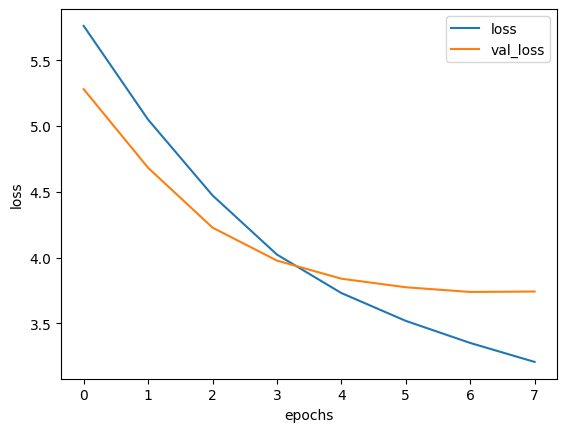

In [82]:
# using rnn_2 and vgg16
import matplotlib.pyplot as plt

for label in ["loss","val_loss"]:
    plt.plot(history.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('models/rnn_2_vgg16_loss.png')
plt.show()

In [83]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = '<start>'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = tokenizer.index_word[yhat]
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == '<end>':
			break
	return in_text

In [84]:
# generate a description for an image using beam search
def generate_desc_beam_search(model, tokenizer, photo, max_length, beam_index=3):
    # seed the generation process
    in_text = [['<start>', 0.0]]
    # iterate over the whole length of the sequence
    for i in range(max_length):
        temp = []
        for s in in_text:
            # integer encode input sequence
            sequence = tokenizer.texts_to_sequences([s[0]])[0]
            # pad input
            sequence = pad_sequences([sequence], maxlen=max_length)
            # predict next words
            preds = model.predict([photo,sequence], verbose=0)
            word_preds = argsort(preds[0])[-beam_index:]
            # get top predictions
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                # map integer to word
                word = tokenizer.index_word[w]
                next_cap += ' ' + word
                prob += preds[0][w]
                temp.append([next_cap, prob])

        in_text = temp
        # sorting according to the probabilities
        in_text = sorted(in_text, reverse=False, key=lambda l: l[1])
        # getting the top words
        in_text = in_text[-beam_index:]

    # get last (best) caption text
    in_text = in_text[-1][0]
    caption_list = []
    # remove leftover <end> 
    for w in in_text.split():
        caption_list.append(w)
        if w == '<end>':
            break
    # convert list to string
    caption = ' '.join(caption_list)
    return caption

In [85]:
def calculate_scores(actual, predicted):
    # calculate BLEU score
    smooth = SmoothingFunction().method4
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smooth)*100
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
    print('BLEU-1: %f' % bleu1)
    print('BLEU-2: %f' % bleu2)
    print('BLEU-3: %f' % bleu3)
    print('BLEU-4: %f' % bleu4)

In [86]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, features, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in tqdm(descriptions.items(), position=0, leave=True):
		# generate description
		yhat = generate_desc(model, tokenizer, features[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	print('Sampling:')
	calculate_scores(actual, predicted)

In [87]:
# evaluate the skill of the model
def evaluate_model_beam_search(model, descriptions, features, tokenizer, max_length, beam_index=3):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in tqdm(descriptions.items(), position=0, leave=True):
		# generate description beam search
		yhat = generate_desc_beam_search(model, tokenizer, features[key], max_length, beam_index)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	print('Beam Search k=%d:' % beam_index)
	calculate_scores(actual, predicted)

In [88]:

# load the model
filename = 'models/rnn_model_2_vgg16.h5'
model = load_model(filename)

In [89]:
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [21:42<00:00,  1.30s/it]


Sampling:
BLEU-1: 56.851469
BLEU-2: 34.568091
BLEU-3: 25.129087
BLEU-4: 12.682147


In [ ]:
# evaluate model beam_search
evaluate_model_beam_search(model, test_descriptions, test_features, tokenizer, max_length, beam_index=3)

 25%|███████████████████████                                                                       | 246/1000 [52:23<2:38:34, 12.62s/it]

In [ ]:
def clean_caption(caption):
    # split caption words
    caption_list = caption.split()
    # remove <start> and <end>
    caption_list = caption_list[1:len(caption_list)-1]
    # convert list to string
    caption = ' '.join(caption_list)
    return caption

In [ ]:
def generate_captions(model, descriptions, features, image_size, count):
    c = 0
    for key, desc_list in descriptions.items():
        # load an image from file
        filename = 'Flickr8k_Dataset/' + key + '.jpg'
        #diplay image
        display(Image(filename))
        # print original descriptions
        for i, desc in enumerate(desc_list):
            print('Original ' + str(i+1) + ': ' + clean_caption(desc_list[i]))
        # generate descriptions
        desc = generate_desc(model, tokenizer, features[key], max_length)
        desc_beam_3 = generate_desc_beam_search(model, tokenizer, features[key], max_length, beam_index=3)
        desc_beam_5 = generate_desc_beam_search(model, tokenizer, features[key], max_length, beam_index=5)
        # calculate BLEU-1 scores
        references = [d.split() for d in desc_list]
        smooth = SmoothingFunction().method4
        desc_bleu = sentence_bleu(references, desc.split(), weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
        desc_beam_3_bleu = sentence_bleu(references, desc_beam_3.split(), weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
        desc_beam_5_bleu = sentence_bleu(references, desc_beam_5.split(), weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
        # print descriptions with scores
        print('Sampling (BLEU-1: %f): %s' % (desc_bleu, clean_caption(desc)))
        print('Beam Search k=3 (BLEU-1: %f): %s' % (desc_beam_3_bleu, clean_caption(desc_beam_3)))
        print('Beam Search k=5 (BLEU-1: %f): %s' % (desc_beam_5_bleu, clean_caption(desc_beam_5)))
        c += 1
        if c == count:
            break

In [ ]:
# load the tokenizer
tokenizer = load(open('files/tokenizer.pkl', 'rb'))

In [ ]:
# load the model
filename = 'models/rnn_model_2_vgg16.h5'
rnn_model = load_model(filename)
# using rnn_2 and vgg16 model
generate_captions(rnn_model, test_descriptions, test_features, 224, 10)